# **0. Imports**

In [101]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import pearsonr
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

In [102]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [16, 9]
    plt.rcParams['font.size'] = 24
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## **0.1 Load Dataset**

In [12]:
data = pd.read_csv('../data/data_trab2_econometria.csv', parse_dates=['Data'])
crb = pd.read_csv('../data/^cry_m.csv')
data.head()

,Data,inflacao,cambio,juros
0,2003-01-01,"1,98","3,44","26,38"
1,2003-01-01,"2,19","3,59","24,31"
2,2003-01-01,"1,14","3,45","23,58"
3,2003-01-01,"1,14","3,12","24,90"
4,2003-01-01,"0,85","2,95","26,38"


# **1.0 Data Description**

In [13]:
df1 = data.copy()

## **1.1 Rename columns**

In [14]:
cols_new = ['date','cpi', 'exchange_rate','interest_rate']
df1.columns = cols_new

## **1.2 Data Dimensions**

In [15]:
print('Number of rows:', format(df1.shape[0]))
print('Number of columns:', format(df1.shape[1]))

Number of rows: 223
Number of columns: 4


## **1.3 Data types**

In [16]:
df1.dtypes

date             datetime64[ns]
cpi                      object
exchange_rate            object
interest_rate            object
dtype: object

## **1.4 Check NA**

In [17]:
df1.isna().sum()

date             0
cpi              0
exchange_rate    0
interest_rate    0
dtype: int64

## **1.5 Change Types**

In [18]:
df1['date'] = pd.to_datetime(df1['date'].astype(str))
#change comma to point decimal

cols = ['cpi', 'exchange_rate', 'interest_rate']

for col in cols:
    df1[col] = df1[col].apply(lambda x: x.replace(',', '.'))



In [19]:
df1['cpi'] = df1['cpi'].astype('float64')
df1['exchange_rate'] = df1['exchange_rate'].astype('float64')
df1['interest_rate'] = df1['interest_rate'].astype('float64')


## **1.6 Descriptive Statistical**

In [20]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])
num_attributes

,cpi,exchange_rate,interest_rate
0,1.98,3.44,26.38
1,2.19,3.59,24.31
2,1.14,3.45,23.58
3,1.14,3.12,24.90
4,0.85,2.95,26.38
...,...,...,...
218,0.93,5.65,2.43
219,0.60,5.56,2.55
220,0.44,5.29,3.29
221,0.83,5.03,3.78


### **1.5.1 Numerical Attributes**

In [21]:
#Central Tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concat
m = pd.concat([d1, d2, d3, d4, ct1, ct2, d5, d6]).T.reset_index()
#m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
#m
m.columns = ['Attributes', 'Std', 'min', 'max', 'Range', 'mean', 'median', 'Skew', 'Kurtosis']
m

,Attributes,Std,min,max,Range,mean,median,Skew,Kurtosis
0,cpi,0.340103,-0.59,2.19,2.78,0.473004,0.44,1.081433,3.933787
1,exchange_rate,1.031950,1.56,5.65,4.09,2.807892,2.41,1.035665,0.447822
2,interest_rate,5.123448,1.57,28.02,26.45,11.362825,10.95,0.570216,0.615377


# **2.0 Modelling**

In [22]:
df2 = df1.copy()
df2.dtypes

date             datetime64[ns]
cpi                     float64
exchange_rate           float64
interest_rate           float64
dtype: object

## **2.1 Plotting series**

In [23]:
crb = crb['Close']
df2['crb_index'] = crb 

Text(0.5, 1.0, 'CRB Index: 2003 - 2021')

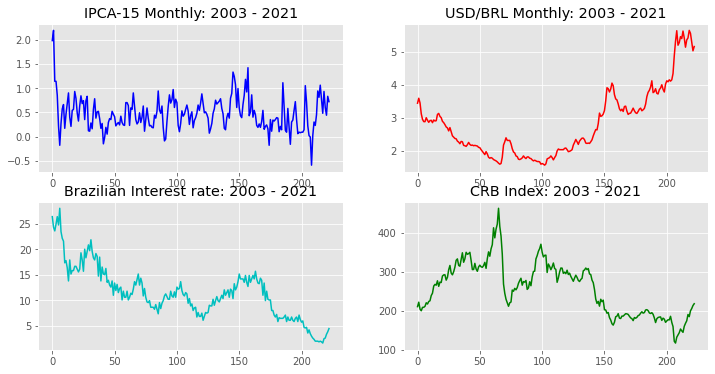

In [24]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(2, 2, 1)
plt.plot(df2['cpi'], color = 'b')
plt.title('IPCA-15 Monthly: 2003 - 2021')

plt.subplot(2, 2, 2)
plt.plot(df2['exchange_rate'], color = 'r')
plt.title('USD/BRL Monthly: 2003 - 2021')

plt.subplot(2, 2, 3)
plt.plot(df2['interest_rate'], color = 'c')
plt.title('Brazilian Interest rate: 2003 - 2021')

plt.subplot(2, 2, 4)
plt.plot(df2['crb_index'], color = 'g')
plt.title('CRB Index: 2003 - 2021')


## **2.2 Check if series are stacionary**

In [25]:
df2.head()

,date,cpi,exchange_rate,interest_rate,crb_index
0,2003-01-01,1.98,3.44,26.38,210.61
1,2003-01-01,2.19,3.59,24.31,221.97
2,2003-01-01,1.14,3.45,23.58,204.24
3,2003-01-01,1.14,3.12,24.90,199.95
4,2003-01-01,0.85,2.95,26.38,208.64


In [26]:
df3 = df2.copy()

### **2.2.1 ADF Test (CPI)**

In [27]:
from statsmodels.tsa.stattools import adfuller
#Null hypothesis = Serie is stationary
result = adfuller(df2['cpi'])
print(f'ADF Test:{result[0]}')
print(f'p-value: {result[1]}')
print(f'Our p-value was {result[1]} > 0.05.')

ADF Test:-2.692329475988519
p-value: 0.07537503614345596
Our p-value was 0.07537503614345596 > 0.05.


In [28]:
result1 = adfuller(df2['exchange_rate'])
print(f'ADF Test:{result1[0]}')
print(f'p-value: {result1[1]}')
print(f'Our p-value was {result1[1]} > 0.05.')




ADF Test:-0.04510485610230285
p-value: 0.9546391560927899
Our p-value was 0.9546391560927899 > 0.05.


In [29]:

result2 = adfuller(df2['interest_rate'])
print(f'ADF Test:{result2[0]}')
print(f'p-value: {result2[1]}')
print(f'Our p-value was {result2[1]} > 0.05.')


ADF Test:-1.6915078005282496
p-value: 0.43549313950646484
Our p-value was 0.43549313950646484 > 0.05.


In [30]:

result3 = adfuller(df2['crb_index'])
print(f'ADF Test:{result3[0]}')
print(f'p-value: {result3[1]}')
print(f'Our p-value was {result3[1]} > 0.05.')

ADF Test:-2.1789556968976864
p-value: 0.21397178189485766
Our p-value was 0.21397178189485766 > 0.05.


### **2.2.2 KPSS**

In [31]:
# KPSS Test
from statsmodels.tsa.stattools import kpss #Null hypothesis -> series is not statacionary
def kpss_test(timeseries):
    print("Result of KPSS Test:")
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index = ['Test Statistic', 'p-value', 'Lags used']
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)"%key] = value
    print(kpss_output)

In [32]:
#KPSS test for CPI is > 0.05 reject the null hypothesis (serie is  stationary )
kpss_test(df2['cpi'])


Result of KPSS Test:
Test Statistic           0.162627
p-value                  0.100000
Lags used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [33]:
#KPSS test for CPI is > null hypothesis (serie is  stationary )
kpss_test(df2['interest_rate'])

Result of KPSS Test:
Test Statistic           1.471083
p-value                  0.010000
Lags used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [34]:
#KPSS test for CPI is > null hypothesis (serie is  stationary )
kpss_test(df2['exchange_rate'])

Result of KPSS Test:
Test Statistic           1.314578
p-value                  0.010000
Lags used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [35]:
#KPSS test for CPI is > null hypothesis (serie is  stationary )
kpss_test(df2['crb_index'])

Result of KPSS Test:
Test Statistic           1.299579
p-value                  0.010000
Lags used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


# **3.0 Diff**

In [36]:
df3 = df2.copy()

In [37]:
from statsmodels.tsa.statespace.tools import diff
df3['cpi'] = np.log(df3['cpi']).diff()
df3['exchange_rate'] = np.log(df3['exchange_rate']).diff()
df3['interest_rate'] = np.log(df3['interest_rate']).diff()
df3['crb_index'] = np.log(df3['crb_index']).diff()
df3.dropna(inplace=True)


c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'CRB Index: 2003 - 2021')

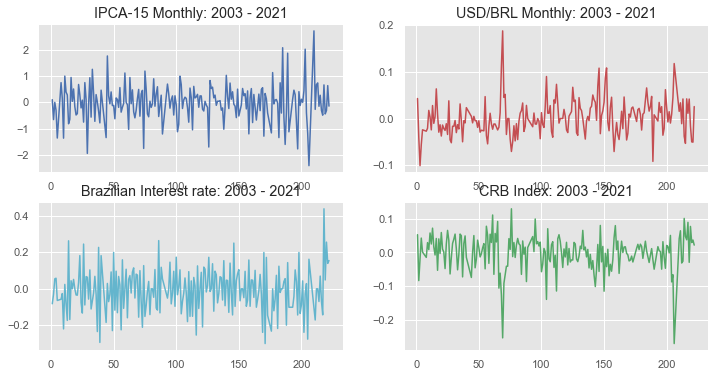

In [103]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(2, 2, 1)
plt.plot(df3['cpi'], color = 'b')
plt.title('IPCA-15 Monthly: 2003 - 2021')

plt.subplot(2, 2, 2)
plt.plot(df3['exchange_rate'], color = 'r')
plt.title('USD/BRL Monthly: 2003 - 2021')

plt.subplot(2, 2, 3)
plt.plot(df3['interest_rate'], color = 'c')
plt.title('Brazilian Interest rate: 2003 - 2021')

plt.subplot(2, 2, 4)
plt.plot(df3['crb_index'], color = 'g')
plt.title('CRB Index: 2003 - 2021')


## **3.1 ADF in Diff**

In [38]:
result1 = adfuller(df3['exchange_rate'])
print(f'ADF Test:{result1[0]}')
print(f'p-value: {result1[1]}')
#print(f'Our p-value was {result1[1]} < 0.05.')




ADF Test:-9.713128288918794
p-value: 9.992097910416985e-17


In [39]:

result2 = adfuller(df3['interest_rate'])
print(f'ADF Test:{result2[0]}')
print(f'p-value: {result2[1]}')
#print(f'Our p-value was {result2[1]} < 0.05.')


ADF Test:-4.4612448153197475
p-value: 0.00023089899660340112


In [40]:

result3 = adfuller(df3['crb_index'])
print(f'ADF Test:{result3[0]}')
print(f'p-value: {result3[1]}')
#print(f'Our p-value was {result3[1]} < 0.05.')

ADF Test:-5.902383944359276
p-value: 2.75858002389106e-07


# **4.0 Testing Causation using Granger’s Causality Test**

In [59]:
df4 = df3.copy()

'''
The basis behind Vector AutoRegression is that each of the time series in the system influences each other.
 That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

'''

'\nThe basis behind Vector AutoRegression is that each of the time series in the system influences each other.\n That is, you can predict the series with past values of itself along with other series in the system.\n\nUsing Granger’s Causality Test, it’s possible to test this relationship before even building the model.\n\n'

In [96]:
df42 = df4[['cpi', 'exchange_rate', 'interest_rate', 'crb_index']].copy()

In [118]:
# make a VAR model
model = VAR(df42)
results = model.fit(2)
results.summary()

c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 24, Sep, 2021
Time:                     07:04:40
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -17.4195
Nobs:                     205.000    HQIC:                  -17.7670
Log likelihood:           717.780    FPE:                1.51875e-08
AIC:                     -18.0030    Det(Omega_mle):     1.27893e-08
--------------------------------------------------------------------
Results for equation cpi
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.029010         0.045720           -0.635           0.526
L1.cpi                  -0.309736         0.067154           -4.612           0.000
L1.exchange_rate         1.988191         1.451332

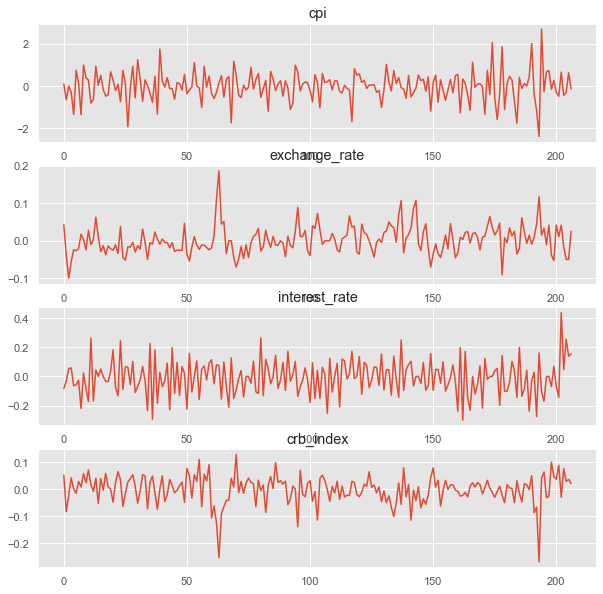

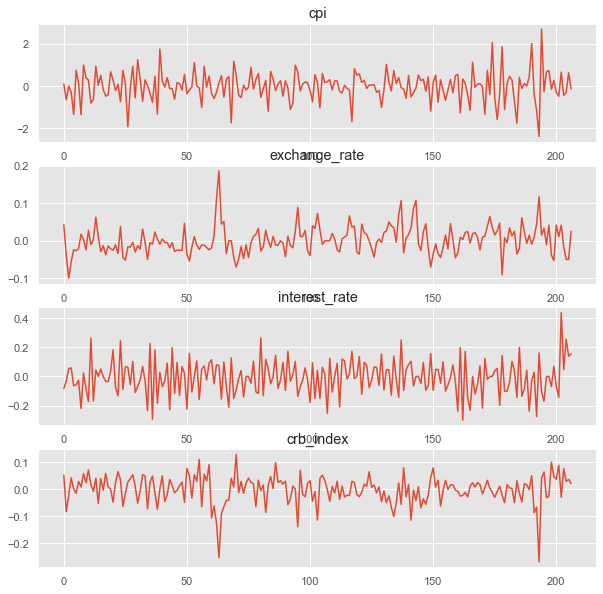

In [119]:
results.plot()

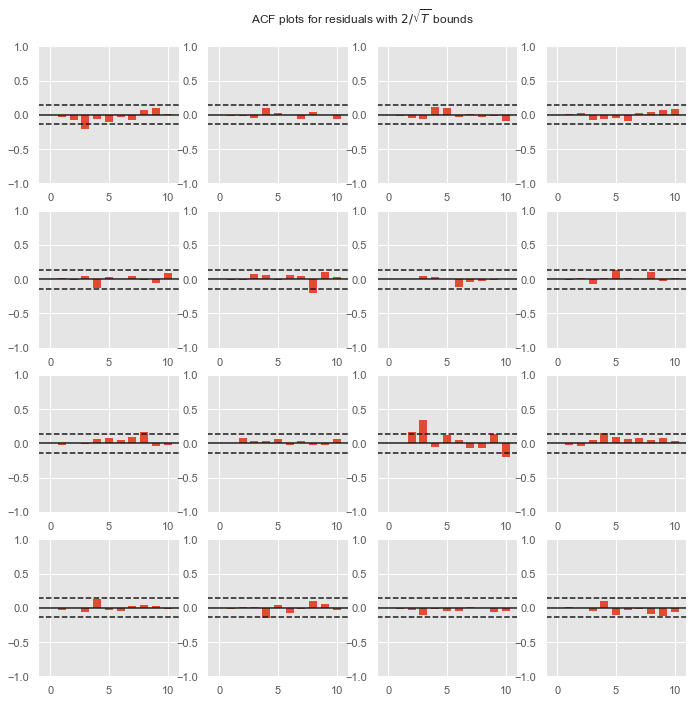

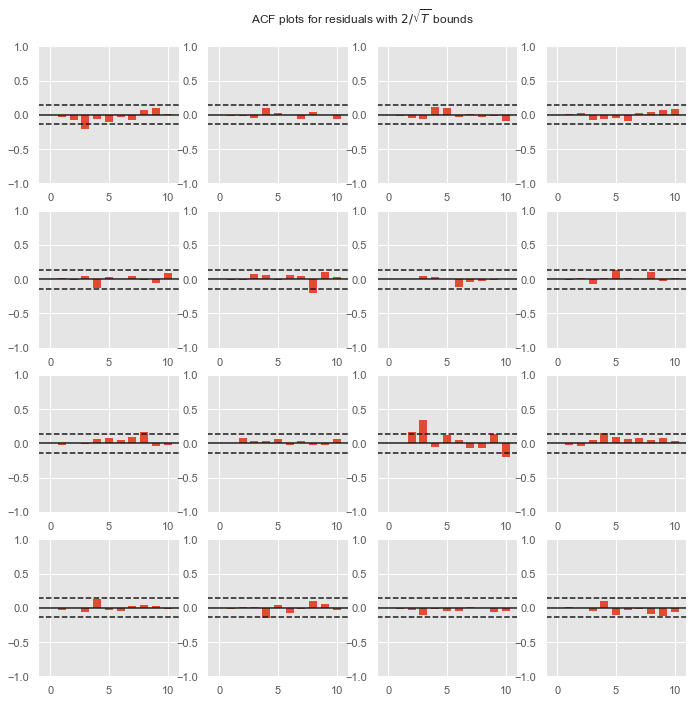

In [122]:
#Plotting time series autocorrelation function
results.plot_acorr()